KeyboardInterrupt: 

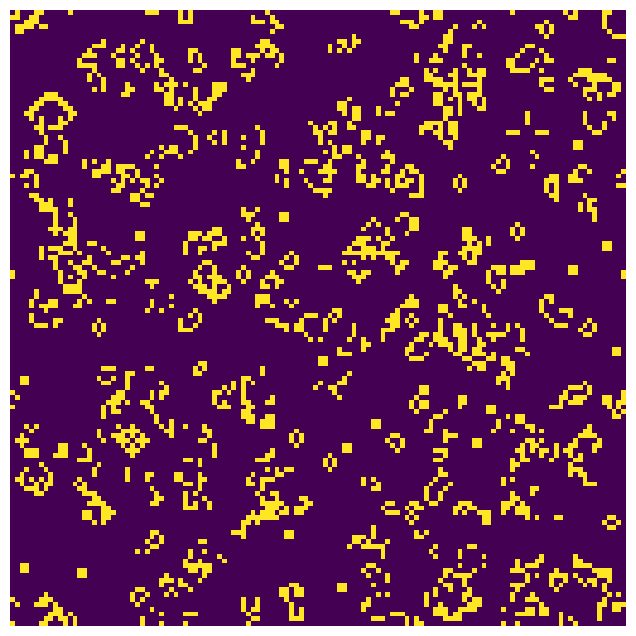

In [12]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import random
import time
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import os, shutil, subprocess

# Parameters
init_proba = 0.2
grid_shape = [128, 128]
nb_steps = 2000
time_step = 0.1
video_size_factor = 5
video_frame_rate = 5
tmp_dir = 'img'
interactive_visual = True
video_encoding = False


# *********************************************************


def init_random_grid(grid, init_proba):
  for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
      grid[i, j] = float(random.uniform(0.0, 1.0) < init_proba)

def init_grid(grid):
  init_random_grid(grid, init_proba)

kernel = np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]])
def update_grid(grid):
  tmp_grid = convolve2d(grid, kernel, mode='same', boundary='wrap')
  death_indexes = np.logical_and(grid == 1.0, np.logical_or(tmp_grid < 2, tmp_grid > 3))
  birth_indexes = np.logical_and(grid == 0.0, tmp_grid == 3)
  tmp_grid = np.copy(grid)
  tmp_grid[death_indexes] = 0.0
  tmp_grid[birth_indexes] = 1.0
  return tmp_grid


grid = np.zeros(grid_shape)
init_grid(grid)

if video_encoding:
  shutil.rmtree(tmp_dir, ignore_errors=True)
  os.mkdir(tmp_dir)

if interactive_visual:
  plt.ion()
  figure, ax = plt.subplots(figsize=(10, 8))
  img = ax.imshow(grid, cmap='viridis')
  ax.axis('off')
  ax.set_frame_on(False)

counter = 0
for step in range(nb_steps) if interactive_visual else tqdm(range(nb_steps)):
  if interactive_visual:
    img.set_array(grid)
    display(figure)
    clear_output(wait=True)
    time.sleep(time_step)
  if video_encoding:
    filename = f"img/im_{counter:03d}.png"
    plt.imsave(filename, grid)
  grid = update_grid(grid)
  counter += 1

if video_encoding:
  cmd = f"ffmpeg -y -framerate {video_frame_rate} -pattern_type glob -i '{tmp_dir}/*.png' -vf scale={grid_shape[0]*video_size_factor}:{grid_shape[1]*video_size_factor}:flags=neighbor -c:v libx264 -preset slow -crf 17 -pix_fmt yuv420p -movflags +faststart out.mp4"
  res = subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
  shutil.rmtree(tmp_dir, ignore_errors=True)
